In [18]:
import numpy as np
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorboard.plugins import projector

# Load data
data = pd.read_csv('/Users/amaterasu/Documents/ai/mnist_test.csv')
data = data.values.astype('float32')

# Split data into training and testing sets
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Reshape and normalize the images
image_size = 28
image_size_new = 32

train_images = train_data[:, 1:] / 255
train_images = train_images.reshape(-1, image_size, image_size, 1)
train_images = np.pad(train_images, [(0, 0), (2, 2), (2, 2), (0, 0)], mode='constant')

test_images = test_data[:, 1:] / 255
test_images = test_images.reshape(-1, image_size, image_size, 1)
test_images = np.pad(test_images, [(0, 0), (2, 2), (2, 2), (0, 0)], mode='constant')

train_labels = train_data[:, 0].astype('int32')
test_labels = test_data[:, 0].astype('int32')

# Define the CNN architecture
def cnn_model(images):
    conv1 = tf.layers.conv2d(images, filters=32, kernel_size=(5, 5), activation=tf.nn.relu, padding='valid')
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=(2, 2), strides=(2, 2), padding='valid')
    conv2 = tf.layers.conv2d(pool1, filters=64, kernel_size=(3, 3), activation=tf.nn.relu, padding='valid')
    pool2 = tf.layers.max_pooling2d(conv2, pool_size=(2, 2), strides=(2, 2), padding='valid')
    flatten = tf.layers.flatten(pool2)
    dense = tf.layers.dense(flatten, units=512, activation=tf.nn.relu)
    output = tf.layers.dense(dense, units=10, activation=None)
    return output

# Create TensorFlow variables and placeholders
batch_size = 64
num_steps = int(train_size / batch_size)
num_epochs = 10

X = tf.placeholder(tf.float32, [None, image_size_new, image_size_new, 1], name='X')
Y = tf.placeholder(tf.int32, [None], name='Y')

logits = cnn_model(X)
prediction = tf.argmax(logits, axis=1)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss_op)

# Evaluate model
accuracy_op = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.cast(Y, tf.int64)), tf.float32))


# Configure TensorBoard embeddings
PATH = '/Users/amaterasu/Documents/ai'
logdir = PATH + '/logs_Mnist'
metadata_path = os.path.join(logdir, 'metadata.tsv')
sprite_image_path = os.path.join(logdir, 'sprite.png')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = logits.name
embedding.metadata_path = metadata_path
embedding.sprite.image_path = sprite_image_path
embedding.sprite.single_image_dim.extend([image_size_new, image_size_new])

# Initialize TensorFlow session and saver
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(logdir, 'model.ckpt'))

    # Generate metadata.tsv file
    with open(metadata_path, 'w') as meta:
        meta.write('Index\tLabel\n')
        for index, label in enumerate(test_labels):
            meta.write('{}\t{}\n'.format(index, int(label)))

    # Generate sprite image
    sprite_dim = int(np.sqrt(len(test_images)))
    sprite_image = np.ones((image_size_new * sprite_dim, image_size_new * sprite_dim))
    for i in range(sprite_dim):
        for j in range(sprite_dim):
            image = test_images[i * sprite_dim + j].reshape(image_size_new, image_size_new)
            sprite_image[i * image_size_new: (i + 1) * image_size_new, j * image_size_new: (j + 1) * image_size_new] = image

    # Save sprite image
    plt.imsave(sprite_image_path, sprite_image, cmap='gray')

    # Write embeddings and projector config to TensorBoard log directory
    summary_writer = tf.summary.FileWriter(logdir)
    projector.visualize_embeddings(summary_writer, config)

    # Train the model
    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        train_images = train_data[:, 1:] / 255
        train_images = train_images.reshape(-1, image_size, image_size, 1)
        train_images = np.pad(train_images, [(0, 0), (2, 2), (2, 2), (0, 0)], mode='constant')
        train_labels = train_data[:, 0].astype('int32')

        for step in range(num_steps):
            offset = step * batch_size
            batch_images = train_images[offset:offset + batch_size]
            batch_labels = train_labels[offset:offset + batch_size]

            sess.run(train_op, feed_dict={X: batch_images, Y: batch_labels})

            if step % 100 == 0:
                loss, acc = sess.run([loss_op, accuracy_op], feed_dict={X: batch_images, Y: batch_labels})
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%"
                      .format(epoch + 1, num_epochs, step + 1, num_steps, loss, acc * 100))

    # Test the model
    test_accuracy = sess.run(accuracy_op, feed_dict={X: test_images, Y: test_labels})
    print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


Epoch [1/10], Step [1/124], Loss: 2.0727, Accuracy: 25.00%
Epoch [1/10], Step [101/124], Loss: 0.1478, Accuracy: 98.44%
Epoch [2/10], Step [1/124], Loss: 0.1429, Accuracy: 95.31%
Epoch [2/10], Step [101/124], Loss: 0.0950, Accuracy: 96.88%
Epoch [3/10], Step [1/124], Loss: 0.0232, Accuracy: 100.00%
Epoch [3/10], Step [101/124], Loss: 0.0293, Accuracy: 96.88%
Epoch [4/10], Step [1/124], Loss: 0.0482, Accuracy: 98.44%
Epoch [4/10], Step [101/124], Loss: 0.0123, Accuracy: 100.00%
Epoch [5/10], Step [1/124], Loss: 0.0083, Accuracy: 100.00%
Epoch [5/10], Step [101/124], Loss: 0.0205, Accuracy: 98.44%
Epoch [6/10], Step [1/124], Loss: 0.0163, Accuracy: 100.00%
Epoch [6/10], Step [101/124], Loss: 0.0113, Accuracy: 100.00%
Epoch [7/10], Step [1/124], Loss: 0.0026, Accuracy: 100.00%
Epoch [7/10], Step [101/124], Loss: 0.0079, Accuracy: 100.00%
Epoch [8/10], Step [1/124], Loss: 0.0058, Accuracy: 100.00%
Epoch [8/10], Step [101/124], Loss: 0.0031, Accuracy: 100.00%
Epoch [9/10], Step [1/124], Los

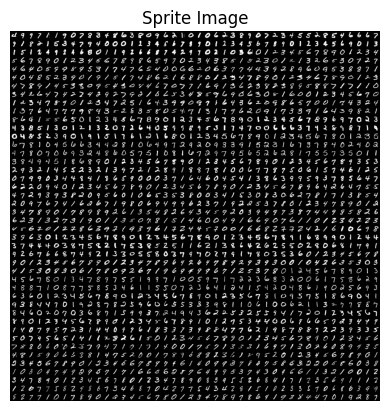

In [19]:
import matplotlib.pyplot as plt

# Load the sprite image
sprite_image = plt.imread(sprite_image_path)

# Plot the sprite image
plt.imshow(sprite_image, cmap='gray')
plt.axis('off')
plt.title('Sprite Image')
plt.show()